# Keras Tuner

Código base: Santiago Hernández

Keras Tuner es una biblioteca que te ayuda a elegir el conjunto óptimo de hiperparámetros para tu programa TensorFlow/Keras. El proceso de seleccionar el conjunto correcto de hiperparámetros para su aplicación de aprendizaje automático (ML) se llama _hyperparameter tuning_ o _hypertuning_.

Los hiperparámetros son las variables que gobiernan el proceso de entrenamiento y la topología de un modelo de Machine Learning. Estas variables permanecen constantes durante el proceso de entrenamiento e impactan directamente en el rendimiento del programa. Los hiperparámetros puden ser de dos tipos:

* **Hiperparámetros del modelo** que influyen en la selección del modelo, como el número y el ancho de las _hidden layers_
* **Hiperparámetros del algoritmo** que influyen en la velocidad y la calidad del algoritmo de aprendizaje, como la tasa de aprendizaje para el Descenso de Gradiente Estocástico (SGD). 

## 0. Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

## 1. Conjunto de datos

In [2]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

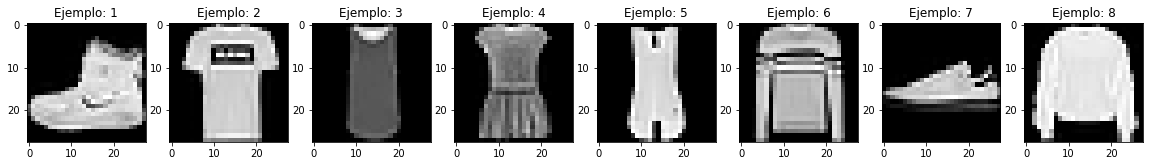

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

for index, e in enumerate(img_train[:8]):
    plt.subplot(1, 8, index+1)
    plt.imshow(e, cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index+1))
    
plt.show()

In [4]:
# Normalizamos el valor de los pixels entre 0 y 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## 2. Definición del modelo

Cuando se construye un modelo para realizar _hypertuning_, debe definirse el espacio de búsqueda de hiperparámetros además de la arquitectura del modelo. El modelo que estableces para realizar _hypertuning_ se llama _hypermodel_.

Puedes definir un _hypermodel_ a través de dos enfoques:

* Implementando una función que construye el modelo
* Creando una subclase la clase `HyperModel` de la Keras Tuner API

También puedes utilizar dos clases predefinidas de `HyperModel`, `HyperXception` y `HyperResNet` para aplicaciones de visión artificial.

En este tutorial, se implementa una función que construye un modelo de clasificación de imágenes. La función devuelve un modelo compilado y utiliza los hiperparámetros que se definan para realizar _hypertuning_ del mismo.

In [5]:
def model_builder(hp):
    
    # Definición del modelo
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    
    # Tunning del número de neuronas de la primera hidden layer
    # Seleccionamos el valor optimo entre 32 y 512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation='relu'))
    
    # Tunning del ratio de aprendizaje para el algoritmo de optimizacion
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    return model


El parámetro `hp` que recibe la función, se corresponde con un objeto de la clase `HyperParameters`, que, de manera general, se corresponde con un "almacén" de hiperparámetros.

## 3. Instanciando el objeto Tuner para realizar _hypertuning_

Una vez definida la función anterior, se instancia el Tuner para realizar el _hypertuning_. El _Keras Tuner_ tiene cuatro _tuners_ disponibles - `RandomSearch`, `Hyperband`, `BayesianOptimization` y `Sklearn`. En este tutorial, se utiliza `Hyperband` (https://arxiv.org/pdf/1603.06560.pdf)

Para instanciar el _tuner_ de Hyperband, hay que especificar el _hypermodel_, el objetivo a optimizar y el número máximo de epochs a entrenar (max_epochs).

In [6]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy', 
    max_epochs = 10,
    factor = 3,
    directory = 'test_dir',
    project_name = 'hp_tuning'
)

INFO:tensorflow:Reloading Oracle from existing project test_dir\hp_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from test_dir\hp_tuning\tuner0.json


El algoritmo `Hyperband` utiliza la asignación adaptativa de recursos y la detención temprana para converger rápidamente en un modelo de alto rendimiento. El algoritmo entrena un gran número de modelos durante unos pocos epochs y lleva a la siguiente ronda sólo la mitad de los modelos de mayor rendimiento. Hyperband determina el número de modelos a entrenar mediante la fórmula $1 + log_{factor}(max\_epochs)$ y redondea el resultado al entero más cercano.

In [7]:
# Ejecución del tuner para la búsqueda de hiperparámetros
tuner.search(
    img_train, 
    label_train, 
    epochs = 10, 
    validation_data = (img_test, label_test)
)

INFO:tensorflow:Oracle triggered exit


Una vez que hemos realizado la búsqueda de los hiperparámetros podemos acceder a los valores óptimos mediante la siugiente sentencia

In [8]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Learning rate:", best_hps.get('learning_rate'))

Units: 256
Learning rate: 0.0001


## 5. Entrenamiento del modelo

Una vez seleccionados los hiperparámetros óptimos, los utilizamos para entrenar el modelo.

In [9]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test)
)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 5.5440 - accuracy: 0.06 - ETA: 4s - loss: 5.3633 - accuracy: 0.07 - ETA: 3s - loss: 5.1272 - accuracy: 0.12 - ETA: 3s - loss: 4.9086 - accuracy: 0.17 - ETA: 3s - loss: 4.6985 - accuracy: 0.20 - ETA: 3s - loss: 4.5209 - accuracy: 0.23 - ETA: 3s - loss: 4.3449 - accuracy: 0.25 - ETA: 3s - loss: 4.1759 - accuracy: 0.28 - ETA: 3s - loss: 4.0391 - accuracy: 0.30 - ETA: 3s - loss: 3.8946 - accuracy: 0.32 - ETA: 3s - loss: 3.7922 - accuracy: 0.34 - ETA: 3s - loss: 3.7066 - accuracy: 0.35 - ETA: 3s - loss: 3.6217 - accuracy: 0.36 - ETA: 3s - loss: 3.5363 - accuracy: 0.37 - ETA: 2s - loss: 3.4548 - accuracy: 0.39 - ETA: 2s - loss: 3.3920 - accuracy: 0.40 - ETA: 2s - loss: 3.3290 - accuracy: 0.40 - ETA: 2s - loss: 3.2803 - accuracy: 0.41 - ETA: 2s - loss: 3.2393 - accuracy: 0.42 - ETA: 2s - loss: 3.1990 - accuracy: 0.43 - ETA: 2s - loss: 3.1501 - accuracy: 0.43 - ETA: 2s - loss: 3.1078 - accuracy: 0.44 - ETA: 2s - loss: 3.06

1875/1875 [==============================] - ETA: 0s - loss: 1.0937 - accuracy: 0.75 - ETA: 3s - loss: 1.4313 - accuracy: 0.70 - ETA: 3s - loss: 1.3930 - accuracy: 0.71 - ETA: 3s - loss: 1.4096 - accuracy: 0.71 - ETA: 3s - loss: 1.4074 - accuracy: 0.70 - ETA: 3s - loss: 1.4074 - accuracy: 0.70 - ETA: 3s - loss: 1.3962 - accuracy: 0.70 - ETA: 3s - loss: 1.3987 - accuracy: 0.70 - ETA: 3s - loss: 1.3888 - accuracy: 0.70 - ETA: 3s - loss: 1.3818 - accuracy: 0.70 - ETA: 3s - loss: 1.3756 - accuracy: 0.70 - ETA: 3s - loss: 1.3753 - accuracy: 0.70 - ETA: 2s - loss: 1.3717 - accuracy: 0.70 - ETA: 2s - loss: 1.3757 - accuracy: 0.70 - ETA: 2s - loss: 1.3641 - accuracy: 0.70 - ETA: 2s - loss: 1.3584 - accuracy: 0.71 - ETA: 2s - loss: 1.3585 - accuracy: 0.71 - ETA: 2s - loss: 1.3558 - accuracy: 0.71 - ETA: 2s - loss: 1.3583 - accuracy: 0.71 - ETA: 2s - loss: 1.3550 - accuracy: 0.71 - ETA: 2s - loss: 1.3552 - accuracy: 0.71 - ETA: 2s - loss: 1.3551 - accuracy: 0.71 - ETA: 2s - loss: 1.3535 - accura

1875/1875 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.78 - ETA: 3s - loss: 1.0962 - accuracy: 0.76 - ETA: 3s - loss: 1.2233 - accuracy: 0.74 - ETA: 4s - loss: 1.2088 - accuracy: 0.74 - ETA: 4s - loss: 1.2161 - accuracy: 0.74 - ETA: 4s - loss: 1.2310 - accuracy: 0.74 - ETA: 3s - loss: 1.2240 - accuracy: 0.74 - ETA: 3s - loss: 1.2220 - accuracy: 0.74 - ETA: 3s - loss: 1.2218 - accuracy: 0.74 - ETA: 3s - loss: 1.2250 - accuracy: 0.73 - ETA: 3s - loss: 1.2275 - accuracy: 0.73 - ETA: 3s - loss: 1.2242 - accuracy: 0.73 - ETA: 4s - loss: 1.2151 - accuracy: 0.73 - ETA: 4s - loss: 1.2159 - accuracy: 0.73 - ETA: 4s - loss: 1.2144 - accuracy: 0.73 - ETA: 3s - loss: 1.2167 - accuracy: 0.73 - ETA: 3s - loss: 1.2270 - accuracy: 0.73 - ETA: 3s - loss: 1.2226 - accuracy: 0.73 - ETA: 3s - loss: 1.2172 - accuracy: 0.73 - ETA: 3s - loss: 1.2178 - accuracy: 0.73 - ETA: 3s - loss: 1.2179 - accuracy: 0.73 - ETA: 3s - loss: 1.2130 - accuracy: 0.73 - ETA: 3s - loss: 1.2126 - accura

1875/1875 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.75 - ETA: 4s - loss: 1.1865 - accuracy: 0.74 - ETA: 4s - loss: 1.2048 - accuracy: 0.74 - ETA: 4s - loss: 1.1718 - accuracy: 0.74 - ETA: 4s - loss: 1.1561 - accuracy: 0.74 - ETA: 3s - loss: 1.1739 - accuracy: 0.73 - ETA: 3s - loss: 1.1715 - accuracy: 0.73 - ETA: 3s - loss: 1.1910 - accuracy: 0.73 - ETA: 3s - loss: 1.2082 - accuracy: 0.73 - ETA: 3s - loss: 1.1942 - accuracy: 0.73 - ETA: 3s - loss: 1.1837 - accuracy: 0.73 - ETA: 3s - loss: 1.1875 - accuracy: 0.73 - ETA: 3s - loss: 1.1892 - accuracy: 0.73 - ETA: 3s - loss: 1.1891 - accuracy: 0.73 - ETA: 3s - loss: 1.1891 - accuracy: 0.73 - ETA: 3s - loss: 1.1880 - accuracy: 0.73 - ETA: 3s - loss: 1.1896 - accuracy: 0.73 - ETA: 3s - loss: 1.1824 - accuracy: 0.73 - ETA: 3s - loss: 1.1788 - accuracy: 0.73 - ETA: 3s - loss: 1.1782 - accuracy: 0.73 - ETA: 4s - loss: 1.1818 - accuracy: 0.73 - ETA: 4s - loss: 1.1808 - accuracy: 0.73 - ETA: 3s - loss: 1.1801 - accura

1875/1875 [==============================] - ETA: 1s - loss: 1.6103 - accuracy: 0.68 - ETA: 4s - loss: 1.0403 - accuracy: 0.75 - ETA: 4s - loss: 1.0664 - accuracy: 0.76 - ETA: 4s - loss: 1.0625 - accuracy: 0.76 - ETA: 4s - loss: 1.0921 - accuracy: 0.76 - ETA: 4s - loss: 1.0947 - accuracy: 0.76 - ETA: 4s - loss: 1.0977 - accuracy: 0.76 - ETA: 4s - loss: 1.0954 - accuracy: 0.76 - ETA: 3s - loss: 1.1040 - accuracy: 0.76 - ETA: 3s - loss: 1.1084 - accuracy: 0.76 - ETA: 3s - loss: 1.0993 - accuracy: 0.76 - ETA: 3s - loss: 1.1077 - accuracy: 0.75 - ETA: 3s - loss: 1.1020 - accuracy: 0.76 - ETA: 3s - loss: 1.0986 - accuracy: 0.76 - ETA: 3s - loss: 1.0907 - accuracy: 0.76 - ETA: 3s - loss: 1.0944 - accuracy: 0.76 - ETA: 3s - loss: 1.0988 - accuracy: 0.76 - ETA: 3s - loss: 1.0964 - accuracy: 0.76 - ETA: 3s - loss: 1.0968 - accuracy: 0.76 - ETA: 3s - loss: 1.0948 - accuracy: 0.76 - ETA: 3s - loss: 1.0957 - accuracy: 0.76 - ETA: 3s - loss: 1.0969 - accuracy: 0.76 - ETA: 3s - loss: 1.0960 - accura

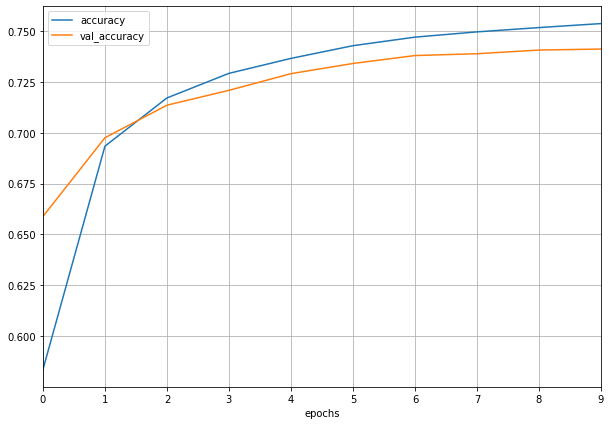

In [10]:
import pandas as pd

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.show()